In [1]:
import numpy as np
from scipy.stats import spearmanr
import pandas as pd
import seaborn as sns

import urllib.request
import os

from rdkit import Chem, RDLogger, DataStructs
from rdkit.Chem import Draw, AllChem
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprintAsBitVect, \
                                        GetMACCSKeysFingerprint
from rdkit.Chem.rdmolops import RDKFingerprint
from rdkit import RDConfig
from rdkit.Chem import FragmentCatalog

In [2]:
def similarity(fps_CFM, fps_L1000FWD):
    sim = []
    for ind_i, fg in enumerate(fps_CFM):
        sim.append([])
        for ind_j, fg_1 in enumerate(fps_L1000FWD):
            sim[ind_i].append(DataStructs.TanimotoSimilarity(fg,fg_1))
    return sim

In [3]:
def intersection(max_sim, chemicals):
    similarity_table = pd.DataFrame(max_sim)[pd.DataFrame(max_sim)[0] == 1.0]
    similarity_table.columns = ["sim_score", "CFM molecules", "L1000FWD molecules"]
    similarity_list_CFM = list(similarity_table["CFM molecules"])
    similarity_list_L1000FWD = list(similarity_table["L1000FWD molecules"])
    similar_molecules = []
    for ind, numb in enumerate(similarity_list_CFM):
        similar_molecules.append([chemicals["name"][numb], chemicals["cid"][numb], molecules[numb]])
    return similar_molecules

In [4]:
def mol_drawer(sim_func, fps_CFM, fps_L1000FWD, l_mol_objs, l_mol_objs_1):
    sim = sim_func(fps_CFM, fps_L1000FWD) #counting similarity scores
    """
    Creating a list of tuples with simularity /
        score and indexes of molecules in i_mol_objs

    """
    max_sim = []
    for i in range(len(sim)):
        max_sim.append((sim[i][np.argmax(sim[i])],i,np.argmax(sim[i])))
    max_sim = sorted(max_sim)
    """
    Extracting all pairs of identical molecules / 
         from sorted l_mol_objs according to their /
             similarity score to be visialized

    """
    out = []
    for i in range(len(max_sim)):
        if max_sim[len(max_sim)-1-i][0] == 1.0:
            out.append(l_mol_objs[max_sim[len(max_sim)-1-i][1]])
            out.append(l_mol_objs_1[int(max_sim[len(max_sim)-1-i][2])])
            print(max_sim[len(max_sim)-1-i])
            k = i
        else:
            break
    return max_sim, Draw.MolsToGridImage(out, molsPerRow=2)

In [5]:
def request(cids):
    molecules = []
    for cid in cids:
        if cid != '_':
            url = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/' + str(cid) + '/property/CanonicalSMILES/csv'
            response = urllib.request.urlopen(url)
            molecules.append(response.read().decode('utf-8'))
    list_of_molecules = []
    for ind, mol in enumerate(molecules):
        a = mol.split(sep='"')
        molecules[ind] = a[5]
        list_of_molecules.append([chemicals['name'][ind], int(a[4][1:-1]), a[5]])
    return molecules, list_of_molecules

In [6]:
L1000FWD = pd.read_csv("Drugs_metadata.csv")
L1000FWD = L1000FWD[L1000FWD["canonical_smiles"].notna()]
L1000FWD

,pert_id,LSM_id,pert_iname,alt_name,canonical_smiles,inchi_key,inchi_string,molecular_formula,molecular_wt,pert_collection,pert_summary,pert_url,pubchem_cid
0,BRD-A00100033,LSM-1232,nifurtimox,NaN,CC1CS(=O)(=O)CCN1N=Cc2ccc(o2)[N+](=O)[O-],InChIKey=ARFHIAQFJWUCFH-UHFFFAOYSA-N,"InChI=1S/C10H13N3O5S/c1-8-7-19(16,17)5-4-12(8)...",C10H13N3O5S,287.292,BIOA,NaN,http://en.wikipedia.org/wiki/Nifurtimox,6842999
1,BRD-A00520476,LSM-22625,otenzepad,AF-DX 116,CCN(CC)CC1CCCCN1CC(=O)N2c3ccccc3C(=O)Nc4cccnc24,InChIKey=UBRKDAVQCKZSPO-UHFFFAOYSA-N,InChI=1S/C24H31N5O2/c1-3-27(4-2)16-18-10-7-8-1...,C24H31N5O2,421.535,BIOA,NaN,http://www.tocris.com/dispprod.php?ItemId=2135...,107867
2,BRD-A00546892,LSM-1235,biperiden,S1285,OC(CCN1CCCCC1)(C2CC3CC2C=C3)c4ccccc4,InChIKey=YSXKPIUOCJLQIE-UHFFFAOYSA-N,"InChI=1S/C21H29NO/c23-21(19-7-3-1-4-8-19,11-14...",C21H29NO,311.461,BIOA,Biperiden is an antiparkinsonian agent of the ...,"http://en.wikipedia.org/wiki/Biperiden,http://...",92151
3,BRD-A00758722,LSM-1237,noretynodrel,norethynodrel,C[C@@]12CCC3C(CCC4=C3CCC(=O)C4)C2CC[C@@]1(O)C#C,InChIKey=ICTXHFFSOAJUMG-OQPPHWFISA-N,InChI=1S/C20H26O2/c1-3-20(22)11-9-18-17-6-4-13...,C20H26O2,298.419,BIOA,NaN,"http://en.wikipedia.org/wiki/Norethynodrel,htt...",5702095
4,BRD-A00827783,LSM-4299,dyphylline,diprophylline,Cn1c(=O)n(C)c2ncn(CC(O)CO)c2c1=O,InChIKey=KSCFJBIXMNOVSH-UHFFFAOYSA-N,InChI=1S/C10H14N4O4/c1-12-8-7(9(17)13(2)10(12)...,C10H14N4O4,254.243,BIOA,NaN,http://en.wikipedia.org/wiki/Dyphylline,3182
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20398,BRD-M98484762,LSM-14674,BRD-M98484762,NaN,CC=Cc1ccc2n(C[C@H]3[C@H](CO)[C@@H](C(O)=O)[C@@...,InChIKey=FZXWICNJJBUHOD-PZQBUFLKSA-N,InChI=1S/2C21H21FN2O6S/c2*1-2-5-12-8-9-15-19-1...,C42H42F2N4O12S2,448.465,CBLI,NaN,NaN,54660965
20404,BRD-U22633929,LSM-5577,MLS002232309,SID81066786|XMD-1185H,COc1cc(ccc1Nc2ncc3N(C(C)C)C(=O)CCN(C4CCCC4)c3n...,NaN,InChI=1S/C29H41N7O3/c1-19(2)36-24-18-30-29(33-...,C29H41N7O3,535.681,NaN,NaN,NaN,42628535
20418,BRD-U51024685,LSM-43248,HG6-64-1,HG-6-64-01,CCN1CCN(Cc2ccc(NC(=O)c3ccc(C)c(\\C=C\\c4cnc5[n...,NaN,InChI=1S/C32H34F3N5O2/c1-4-39-13-15-40(16-14-3...,C32H34F3N5O2,577.640,NaN,NaN,NaN,53302361
20421,BRD-U61997977,LSM-5545,SCHEMBL17857056,WZ-4-145,COc1cc(OC)c(Cl)c(NC(=O)N(Cc2ccc(NC(=O)C=C)cc2)...,NaN,InChI=1S/C34H36Cl2N8O4/c1-5-30(45)40-24-8-6-22...,C34H36Cl2N8O4,691.607,NaN,NaN,NaN,73707531


In [7]:
chemicals = pd.read_csv("direct_reprogramming_non-genetics.csv")
chemicals

,cid,link,name,Synonyms,MOA
0,459803,https://pubchem.ncbi.nlm.nih.gov/compound/459803,AC1LA18U,NaN,Inhibitor of the HIF prolyl 4-hydroxylase
1,91899426,https://pubchem.ncbi.nlm.nih.gov/compound/9189...,2-phospho-L-ascorbic acid,2-phospho-L-ascorbic acid;BDBM92477,_
2,286003,https://pubchem.ncbi.nlm.nih.gov/compound/286003,DTXSID80301486,NaN,Agonist of the Adenosine Receptor
3,47289,https://pubchem.ncbi.nlm.nih.gov/compound/47289,4-(Methylnitrosamino)-1-(3-pyridyl)-1-butanone,NaN,_
4,451668,https://pubchem.ncbi.nlm.nih.gov/compound/451668,5-Aza-2'-deoxycytidine,Decitabine;5-Aza-2'-deoxycytidine;2353-33-5;Da...,Inhibitor of DNA methylation
...,...,...,...,...,...
153,2814138,https://pubchem.ncbi.nlm.nih.gov/compound/2814138,OAC2,NaN,_
154,5282411,https://pubchem.ncbi.nlm.nih.gov/compound/5282411,Prostaglandin I2,NaN,"Activator of prostaglandin receptors EP1, EP2,..."
155,10202642,https://pubchem.ncbi.nlm.nih.gov/compound/1020...,GW788388,NaN,Inhibitor of Transforming Growth Factor Beta S...
156,6437836,https://pubchem.ncbi.nlm.nih.gov/compound/6437836,Peretinoin,NaN,Agonist of retinoid acid receptor (RAR)


In [8]:
cids = chemicals['cid']
molecules, list_of_molecules = request(cids)

In [9]:
molecules

['C1=CC2=C(C3=C(C=C2)C(=O)C(=CN3)C(=O)O)N=C1',
 'C(C(C1=C(C(=C(O1)O)OP(=O)([O-])[O-])[O-])O)O',
 'CC1(OC2C(O1)C(OC2C(=O)O)N3C=NC4=C(N=CN=C43)N)C',
 'CN(CCCC(=O)C1=CN=CC=C1)N=O',
 'C1C(C(OC1N2C=NC(=NC2=O)N)CO)O',
 'CC1=NC(=CC=C1)C2=NN(C=C2C3=CC=NC4=CC=CC=C34)C(=S)NC5=CC=CC=C5',
 'C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)CO)O)O)N',
 'COC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC(=CC=C3)Cl)OC',
 'CC1(CCC(C2=C1C=CC(=C2)C(=O)NC3=CC=C(C=C3)C(=O)O)(C)C)C',
 'C1=CC=C2C(=C1)C(=O)OC23C4=CC(=C(C(=C4OC5=C(C(=C(C=C35)Br)[O-])Br)Br)[O-])Br.[Na+].[Na+]',
 'C1=CC=C2C(=C1)C=CC(=C2C=NNC(=O)C3=CC=NC=C3)O',
 'CC1=CC(=NN1)NC2=C(C=C(C(=N2)NC(C)C3=CC=C(C=C3)F)C#N)F',
 'CC1=C(C(C(=C(N1)C)[N+](=O)[O-])C2=CC=CC=C2C(F)(F)F)C(=O)OC',
 'CC1=CC2=C(C=C1C(=C)C3=CC=C(C=C3)C(=O)O)C(CCC2(C)C)(C)C',
 'C1=CC=C2C(=C1)C(=C(N2)C3=C(NC4=C3C=CC(=C4)Br)O)N=O',
 'CN1CCCN(CC1)C2=NC3=CC(=C(C=C3C(=N2)NC4CCN(CC4)CC5=CC=CC=C5)OC)OC',
 'CCC1=C(N(N=N1)CC)SCC2=C(N3C(C(C3=O)NC(=O)CS(=O)C4=CC=CS4)SC2)C(=O)O',
 'C1=CC=C(C=C1)CCNC2=C3C4=CC=CC=C4C(=O)C5=C3C(=CC=

In [10]:
l_mol_objs = [Chem.MolFromSmiles(molecule) for molecule in molecules]

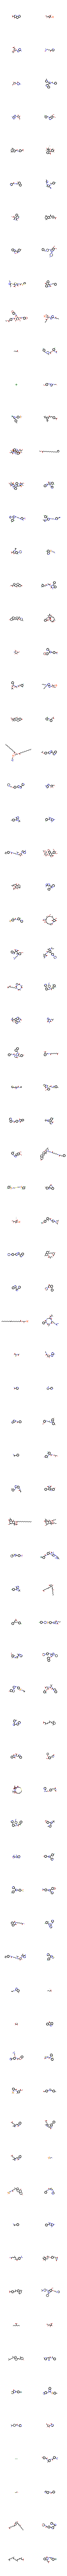

In [11]:
Draw.MolsToGridImage(l_mol_objs, molsPerRow=2)

In [12]:
L1000FWD_molecules = list(L1000FWD["canonical_smiles"])
l_mol_objs_1 = [Chem.MolFromSmiles(molecule) for molecule in L1000FWD_molecules]

In [13]:
L1000FWD_molecules

['CC1CS(=O)(=O)CCN1N=Cc2ccc(o2)[N+](=O)[O-]',
 'CCN(CC)CC1CCCCN1CC(=O)N2c3ccccc3C(=O)Nc4cccnc24',
 'OC(CCN1CCCCC1)(C2CC3CC2C=C3)c4ccccc4',
 'C[C@@]12CCC3C(CCC4=C3CCC(=O)C4)C2CC[C@@]1(O)C#C',
 'Cn1c(=O)n(C)c2ncn(CC(O)CO)c2c1=O',
 'CC(C)NCC(O)COc1ccccc1CC=C',
 'CCC(C(CC)c1ccc(O)cc1)c2ccc(O)cc2',
 'OC[C@H]1O[C@H](C(O)[C@H]1O)n2cccnc2=O',
 'CCCN(C/C=C/I)C1CCc2ccc(O)cc2C1',
 'OCc1cc(ccc1O)C(O)CNCCCCCCOCCCCc2ccccc2',
 'C[C@@H]1CC2C3C[C@H](F)C4=CC(=O)C=C[C@]4(C)[C@@]3(F)[C@@H](O)C[C@]2(C)[C@@]1(O)C(=O)CO',
 'CC(=O)O[C@@]1(CCC2C3C=C(Cl)C4=CC(=O)CC[C@]4(C)C3CC[C@@]21C)C(=O)C',
 'CCCCN1CCCCC1C(=O)Nc2c(C)cccc2C',
 'CC(=O)OCC(=O)[C@@]1(O)CCC2C3CCC4=CC(=O)C=CC4(C)C3[C@@H](O)C[C@@]21C',
 'COc1ccccc1N2CCN(CC(O)COc3cccc4ccccc34)CC2',
 'CCOC(=O)C1=C(C)NC(=C(C1c2cccc(c2)[N+](=O)[O-])C(=O)OC)C',
 'C[C@H]1CC2C3CCC4=CC(=O)C=C[C@]4(C)[C@@]3(F)[C@@H](O)C[C@]2(C)[C@@]1(O)C(=O)CO',
 'C[C@@]12CCC3C(CCc4cc(O)ccc34)C2CC[C@@]1(O)C#C',
 'CCC1(CCCCN(C)C1)c2cccc(O)c2',
 'CC(C)NCC(O)COc1ccc(CCOCC2CC2)cc1',
 'CC(Oc1c(C

In [14]:
fps_CFM = [GetMorganFingerprintAsBitVect(molecule, 2) for molecule in l_mol_objs]
fps_L1000FWD = [GetMorganFingerprintAsBitVect(molecule, 2) for molecule in l_mol_objs_1]

In [15]:
sim = similarity(fps_CFM, fps_L1000FWD)

In [16]:
max_sim, pictures = mol_drawer(similarity, fps_CFM, fps_L1000FWD, l_mol_objs, l_mol_objs_1)

(1.0, 147, 1711)
(1.0, 145, 7)
(1.0, 144, 1192)
(1.0, 143, 2053)
(1.0, 138, 1146)
(1.0, 136, 1290)
(1.0, 135, 70)
(1.0, 134, 1609)
(1.0, 133, 1990)
(1.0, 132, 255)
(1.0, 121, 542)
(1.0, 118, 4951)
(1.0, 117, 2067)
(1.0, 114, 895)
(1.0, 113, 1586)
(1.0, 112, 216)
(1.0, 111, 1382)
(1.0, 107, 510)
(1.0, 105, 199)
(1.0, 104, 1956)
(1.0, 103, 1680)
(1.0, 99, 1706)
(1.0, 95, 935)
(1.0, 94, 2050)
(1.0, 90, 1619)
(1.0, 89, 1860)
(1.0, 87, 1293)
(1.0, 86, 255)
(1.0, 83, 594)
(1.0, 82, 976)
(1.0, 81, 2265)
(1.0, 80, 1456)
(1.0, 77, 950)
(1.0, 75, 664)
(1.0, 74, 587)
(1.0, 73, 860)
(1.0, 71, 1092)
(1.0, 66, 1497)
(1.0, 64, 12517)
(1.0, 62, 10058)
(1.0, 60, 1077)
(1.0, 58, 3094)
(1.0, 55, 2196)
(1.0, 53, 1624)
(1.0, 52, 315)
(1.0, 51, 1102)
(1.0, 48, 1244)
(1.0, 46, 12573)
(1.0, 43, 641)
(1.0, 42, 16)
(1.0, 40, 3274)
(1.0, 39, 661)
(1.0, 38, 2743)
(1.0, 37, 7769)
(1.0, 36, 2855)
(1.0, 34, 1708)
(1.0, 32, 585)
(1.0, 26, 3413)
(1.0, 25, 12100)
(1.0, 24, 560)
(1.0, 23, 2100)
(1.0, 22, 7539)
(1.0, 19,

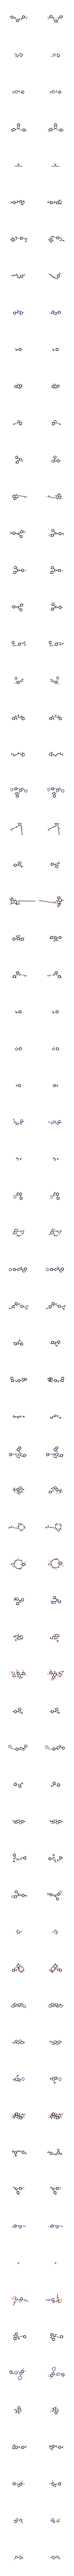

In [17]:
pictures

In [18]:
simular_molecules = pd.DataFrame(intersection(max_sim, chemicals))
simular_molecules.columns = ["name", "CID", "canonical SMILES"]
simular_molecules

,name,CID,canonical SMILES
0,5-Aza-2'-deoxycytidine,451668,C1C(C(OC1N2C=NC(=NC2=O)N)CO)O
1,Adenosine,60961,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)CO)O)O)N
2,AG-1478,2051,COC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC(=CC=C3)Cl)OC
3,AM580,2126,CC1(CCC(C2=C1C=CC(=C2)C(=O)NC3=CC=C(C=C3)C(=O)...
4,Bay k 8644,2303,CC1=C(C(C(=C(N1)C)[N+](=O)[O-])C2=CC=CC=C2C(F)...
...,...,...,...
65,Troglitazone,5591,CCCC(CCC)C(=O)O
66,Vitamin D3,5280795,CC1=CC=C(C=C1)S(=O)(=O)NC2=NC3=CC=CC=C3N=C2NC4...
67,WP 1066,11210478,CC(C1CCC(CC1)C(=O)NC2=CC=NC=C2)N
68,XAV939,135418940,C1=CN(C(=O)N=C1)C2C(C(C(O2)CO)O)O


In [19]:
simular_molecules.to_csv('~/intersection_of_CFM_and_L1000FWD.csv', index=False)

# Creating a Table

In [37]:
reprogramming_data = pd.read_csv("direct_reprogramming_non-genetics_structure.csv")
reprogramming_data

,DOI,Species,Source Cell Type,Target Cell Type,"Duration, d","name of chemical 1,CID 1;name of chemical 2,CID 2",Medium,Growth Factors,Initial Culture (text),MoA chem 1; MoA chem 2,TFs/miRNA,Title,Assocoated Data,Yield (%),Comment on Yield,Type,Comment,"Authors;sorted=""Reverse"";sep=;",Stress factors
0,10.1371/journal.pone.0089678,Mus musculus,Fibroblasts,Induced Cardiomyocytes,14,"SB431542,4521392",doxycycline (2 µg mL−1) and the PGK-H2B-m Cher...,_,"MEFs, isolated at E14.5",Inhibitor of the Activin/BMP/TGF-β pathway,_,Inhibition of TGFβ signaling increases direct ...,GSE54022,16.95,NaN,2,_,John D. Gearhart; Jonathan A. Epstein; Russell...,_
1,10.1007/s12015-013-9477-9,Sus scrofa,Fibroblasts,Induced Pancreatic Beta Cells,36,"5-Aza-2'-deoxycytidine,9444","N2B27 with 0.1 mM β- mercaptoetanol (Sigma), 2...",basic fibroblast growth factor 20 ng/ml,Primary porcine skin fibroblast cultures were ...,Inhibitor of DNA methylation,_,Reprogramming of pig dermal fibroblast into in...,_,38.1,Counting insulin labeled cells with a flow cyt...,1,_,F.; Gandolfi; T. A. L.; Brevini; M. M.; Rahman...,_
2,10.1038/ncomms3183,Homo sapiens,Fibroblasts,Induced Cholinergic Neurons,28,"Forskolin,47936;Dorsomorphin,11524144",_,FGF2 (10 ng ml−1),Human fibroblasts were obtained from commercia...,"CAMP agonist;Inhibitor of ALK2, ALK3, ALK6",NGN2,Small Molecules Enable Neurogenin 2 to Efficie...,GSE45954,57.2,NaN,2,_,Oliver Brüstle; Philipp Koch; Franz-Josef Müll...,_
3,10.1016/j.biocel.2013.04.022,Homo sapiens,Mesenchymal Stem Cells (Bone marrow derived),Induced Neurons,28,"SB431542,4521392;Dorsomorphin,11524144",NeuroCult supplemented with 1% penicillin/stre...,10 ng/ml recombinant human bFGF,8-week fetal forebrain,Inhibitor of the Activin/BMP/TGF-β pathway;Inh...,_,Enhancing the efficiency of direct reprogrammi...,_,1,"Sodium current, Electrophysiological recordings",1,_,Zhiying Zhang; Qing-song Liu;Alexanian Arshak R.,_
4,10.1371/journal.pone.0003531,Mus musculus,Primordial Germ Cells,Induced Pluripotent Epiblast Cells,10,"Trichostatin A,444732","LIF (1200 IU/ml), FGF-2 (25 ng/ml)",FGF-2 (25 ng/ml),"EG cell lines, 8.5 EGC-1 and 4-3 Rosa, were de...",Inhibitor of the histone deacetylases I and II,_,Reprogramming Primordial Germ Cells into Pluri...,_,30,cells were stained for TNAP activity and the n...,2,_,M. Azim Surani; Reuben Tooze; Gina Doody; Fuch...,_
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,10.1038/nmeth.1972,Homo sapiens,Fibroblasts,Induced Neuron-like Cells,23,"SB431542,4521392;LDN193189,25195294;CHIR99021,...",Neuronal medium containing DMEM/F12 (1% (vol/v...,"FGF2, EGF, BDNF, GDNF, NT3",Primary HPFs were established from dissociated...,Inhibitor of the Activin/BMP/TGF-β pathway;Inh...,Noggin,Small molecules enable highly efficient neuron...,GSE36246,80,Tthe percentage of βIII-tub+ cells in relation...,2,_,Oliver Brüstle; Philipp Koch; Franz-Josef Müll...,_
165,10.1007/s11064-012-0819-9,Rattus _,Muscle-derived Stem Cells,Induced Dopaminergic Neurons,14,"Vitamin C,54670067;Forskolin,47936","Neurobasal A, N2, 2 mM L-glutamine, 40 ng/ml b...","bFGF, EGF, SHH, FGF, GDNF",MDSCs were isolated from six-month old Sprague...,_;CAMP agonist,_,Dopaminergic neuronal conversion from adult ra...,_,1.34,Expression of TH,1,_,Xiao-Min Wang; Jun Jia; Ding-Zhen Luo; Zi-Xuan...,_
166,10.1093/humrep/des204,Mus musculus,Testicular Cells,Germline-derived pluripotent stem cells (gPSCs),14,"CHIR99021,9956119","Ko-DMEM, L-glutamine 2 mM, non-essential amino...","GDNF, EGF, bFGF, LIF",Testicular cells were isolated from neonatal m...,Inhibitor of GSK3β,_,Inhibition of glycogen synthase kinase-3 promo...,_,0.065,number of colonies; cells maintained ESC morph...,1,_,Hossein Baharvand; Nasser Aghdami; Hananeh Fon...,_
167,10.5966/sctm.2011-0022,Homo sapiens,Induced Pluripotent Stem Cells,Mesenchymal stem/stromal cells (MSCs),10,"SB431542,4521392",KOSR medium (DMEM‐Ham's F‐12 basal medium supp...,"bFGF, TGF-β",Human iPSCs (MR90CL2 a

In [38]:
out_table = []
for ind, cid in enumerate(simular_molecules["CID"]):
    for ind_1, chem in enumerate(reprogramming_data["name of chemical 1,CID 1;name of chemical 2,CID 2"]):
        chem = chem.split(sep=';')
        for mol in chem:
            mol = mol.split(sep=',')
            if mol[1] != "_" and cid == mol[1]:
                out_table.append([reprogramming_data["Source Cell Type"][ind_1], reprogramming_data["Target Cell Type"][ind_1], simular_molecules["canonical SMILES"][ind]])
out_table = sorted(out_table)
out_table = pd.DataFrame(out_table)
out_table.columns = ["Source Cell Type", "Target Cell Type", "SMILESs of chemicals"]
final_table = []
flag = True
mols = []
for i in range(1, len(out_table)):
    if flag == False:
        final_table.append([str(out_table["Source Cell Type"][i-2]), str(out_table["Target Cell Type"][i-2]), ';'.join(mols)])
        mols = []
        flag = True
    mols.append(str(out_table["SMILESs of chemicals"][i-1]))
    if i == len(out_table) - 1:
        mols.append(str(out_table["SMILESs of chemicals"][i]))
        final_table.append([str(out_table["Source Cell Type"][i-2]), str(out_table["Target Cell Type"][i-2]), ';'.join(mols)])
    if str(out_table["Source Cell Type"][i]) == str(out_table["Source Cell Type"][i-1]) and str(out_table["Target Cell Type"][i]) == str(out_table["Target Cell Type"][i-1]):
        continue
    else:
        flag = False

        
final_table = pd.DataFrame(final_table)
final_table.columns = ["Source Cell Type", "Target Cell Type", "SMILESs of chemicals"]
final_table = final_table.sort_values(by=['Source Cell Type', 'Target Cell Type'])
final_table

,Source Cell Type,Target Cell Type,SMILESs of chemicals
0,Adipose-Derived Stem Cells,Induced Retinal Precursor Cells,C1=CC2=C3C(=C1)C(=O)N(C(=O)C3=CC=C2)CCCCCC(=O)...
1,Alpha Cell,Induced Pancreatic Beta Cells,C1=CC=C(C=C1)CCNC2=C3C4=CC=CC=C4C(=O)C5=C3C(=C...
2,Astrocytes,Induced Dopamine Neurons,C1=CC2=C3C(=C1)C(=O)N(C(=O)C3=CC=C2)CCCCCC(=O)...
3,Astrocytes,Induced Neurons,C1=CC2=C3C(=C1)C(=O)N(C(=O)C3=CC=C2)CCCCCC(=O)...
4,Astrocytes,Induced Oligodendrocytes,C1C(C(OC1N2C=NC(=NC2=O)N)CO)O
...,...,...,...
86,U87MG Glioblastom Cells,Induced Neurons,C1CC1NC(=O)C2=NOC(=C2)C3=CC=CS3;CC(=O)OC1C(C2C...
87,Urine Cells,Induced Hepatocytes,C1=CC(=C(C=C1I)F)NC2=C(C=CC(=C2F)F)C(=O)NOCC(C...
88,Urine Cells,Induced Neurons,C1CC1NC(=O)C2=NOC(=C2)C3=CC=CS3;CC(=O)OC1C(C2C...
89,WB-F344 cells,Induced Pancreatic Beta Cells,C1=CC=C2C(=C1)C(=O)N(C2=O)C(CC3=CNC4=CC=CC=C43...


In [40]:
final_table.to_csv('~/reprogramming_data.csv', index=False)